# 应用：可视化有效前沿

“现代投资组合理论（MPT）”是由哈里·马科维茨在他的论文《投资组合选择》中提出的假设（该论文于1952年由《金融杂志》发表），是一种基于这样一个理念的投资理论：风险厌恶的投资者可以构建投资组合，以优化或最大化基于给定市场风险水平的预期回报。它是处理金融和投资领域最重要和最具影响力的经济理论之一。

本节需要使用pip安装如下库：
```
pip install scipy --user -i https://mirrors.aliyun.com/pypi/simple
```

> SciPy（Scientific Python）是一个开源的Python科学计算库，它构建在NumPy之上，并提供了许多用于科学计算和技术计算的高级功能。SciPy提供了许多用于优化、数值积分、插值、线性代数、统计、信号处理、图像处理、常微分方程求解等方面的功能。



## 读取数据文件

读取名为 'stocks.csv' 的CSV文件，并将其加载到一个名为 stocks 的Pandas DataFrame中。该DataFrame被设置为以日期作为索引，并解析日期列为日期时间对象。

In [1]:
import pandas as pd
stocks = pd.read_csv('datasets/stocks.csv', index_col='Date', parse_dates=True)

In [2]:
stocks.head()

aapl      cisco         ibm    amzn
Date                                                
2012-01-03  53.063218  15.752778  160.830881  179.03
2012-01-04  53.348386  16.057180  160.174781  177.51
2012-01-05  53.940658  15.997991  159.415086  177.61
2012-01-06  54.504543  15.938801  157.584912  182.61
2012-01-09  54.418089  16.040268  156.764786  178.56

处理股票价格，让初始价格为1，并绘制折线图

In [3]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

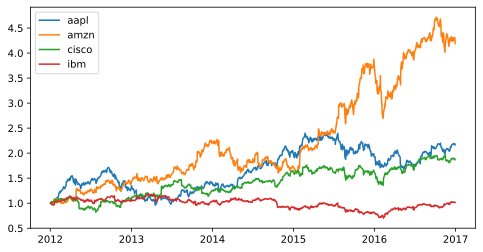

In [26]:
stock_normed = stocks/stocks.iloc[0]
plt.figure(figsize=(8, 4))
plt.plot(stock_normed['aapl'], label='aapl')
plt.plot(stock_normed['amzn'], label='amzn')
plt.plot(stock_normed['cisco'], label='cisco')
plt.plot(stock_normed['ibm'], label='ibm')
plt.legend()

## 计算对数收益率

我们现在将转而使用对数收益率而不是算术收益率，对于我们的许多用例，它们几乎相同，但大多数技术分析需要对时间序列进行去趋势化/归一化，使用[对数收益率是一个不错的方法](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)。对数收益率在我们将遇到的许多算法中非常方便使用。


In [5]:
import numpy as np
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

aapl     cisco       ibm      amzn
Date                                              
2012-01-03       NaN       NaN       NaN       NaN
2012-01-04  0.005360  0.019139 -0.004088 -0.008526
2012-01-05  0.011041 -0.003693 -0.004754  0.000563
2012-01-06  0.010400 -0.003707 -0.011547  0.027763
2012-01-09 -0.001587  0.006346 -0.005218 -0.022428

## 收益率的分布

绘制对数收益率的频数分布图

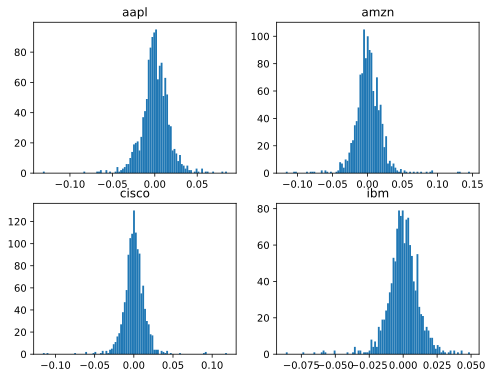

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6)) 
ax[0,0].hist(log_ret['aapl'], bins=100)
ax[0,1].hist(log_ret['amzn'], bins=100)
ax[1,0].hist(log_ret['cisco'], bins=100)
ax[1,1].hist(log_ret['ibm'], bins=100)
ax[0,0].set_title('aapl')
ax[0,1].set_title('amzn')
ax[1,0].set_title('cisco')
ax[1,1].set_title('ibm')
plt.show()

## 描述性统计

In [7]:
log_ret.describe().transpose()

count      mean       std       min       25%       50%       75%  \
aapl   1257.0  0.000614  0.016466 -0.131875 -0.007358  0.000455  0.009724   
cisco  1257.0  0.000497  0.014279 -0.116091 -0.006240  0.000213  0.007634   
ibm    1257.0  0.000011  0.011819 -0.086419 -0.005873  0.000049  0.006477   
amzn   1257.0  0.001139  0.019362 -0.116503 -0.008534  0.000563  0.011407   

            max  
aapl   0.085022  
cisco  0.118862  
ibm    0.049130  
amzn   0.146225

## 模拟成千上万种可能的资产配置

### 循环并计算每次模拟情况

In [8]:
# 模拟次数
num_ports = 10000

# 初始化
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # 产生随机权重
    weights = np.array(np.random.random(4))

    # 权重归一化，总和为1
    weights = weights / np.sum(weights)
    
    # 记录权重
    all_weights[ind,:] = weights

    # 预期收益率
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # 预期波动率（方差）
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # 夏普比率
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

### 绘制模拟情况
1. 设置图片尺寸为宽度6英寸，高度4英寸
2. 绘制散点图，点的大小为10，设置颜色为夏普比率的值，配色方案为一种渐变的"plasma"方案
3. 添加颜色条

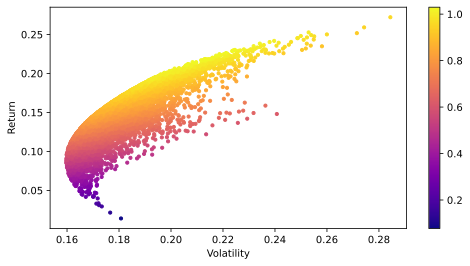

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(vol_arr, ret_arr, s=10, c=sharpe_arr, cmap='plasma')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar()

## 组合优化


### 计算收益率、波动和夏普比率的函数

In [10]:
def get_ret_vol_sr(weights):
    """
    把收益率、波动和夏普比率放进一个函数
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [11]:
from scipy.optimize import minimize

scipy.optimize：提供了用于优化问题的函数，包括最小化和最大化目标函数、非线性方程求解、拟合曲线等功能。

进一步了解minimize如何使用，参见 [`scipy.optimize.minimize` 文档](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)。

### 最大化夏普比率

优化工作是作为一个最小化函数进行的，因为我们实际上想要最大化夏普比率，所以我们需要将其转为负数，这样我们才能最小化负夏普（与最大化正夏普相同）。

In [12]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [13]:
# 检查权重的和
def check_sum(weights):
    '''
    如果权重总和为1，返回0
    '''
    return np.sum(weights) - 1

In [14]:
# 按照最小化函数的惯例，它应该是一个在特定条件下返回零的函数。
cons = ({'type':'eq','fun': check_sum})

In [15]:
# 每个权重的范围
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [16]:
# 初始化权重，例如等权重
init_guess = [0.25,0.25,0.25,0.25]

In [17]:
# 开始最小化
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

优化完的结果如下

In [18]:
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0307168703358962
       x: [ 2.663e-01  2.042e-01  4.375e-17  5.295e-01]
     nit: 7
     jac: [ 5.643e-05  4.184e-05  3.399e-01 -4.449e-05]
    nfev: 35
    njev: 7

最佳权重如下：

In [19]:
opt_results.x

array([2.66289766e-01, 2.04189821e-01, 4.37543339e-17, 5.29520412e-01])

对应的收益率(ret)、波动率(vol)和夏普比率(sr)值如下：

In [20]:
get_ret_vol_sr(opt_results.x)

array([0.21885916, 0.21233683, 1.03071687])

### 有效前沿（Efficient Frontier）

有效边界是一组最优投资组合，它为一定风险水平提供了最高的预期回报，或者对于给定预期回报水平提供了最低的风险。位于有效边界下方的投资组合是次优的，因为它们没有提供足够的回报来抵消风险水平。位于有效边界右侧的投资组合也是次优的，因为它们对于给定的预期回报率而言具有更高的风险水平。

首先，指定有效前沿在y轴上的坐标范围，如0-0.3，中间生成100个点

In [21]:
frontier_y = np.linspace(0,0.3,100)  

In [22]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

在每次循环过程中，设置约束条件：
1. 总权重之和 - 1 = 0
2. 寻找最小波动时，计算出的组合收益率 - 给定的波动率 = 0

In [23]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun': check_sum},              
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})       
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

In [24]:
len(ret_arr)

10000

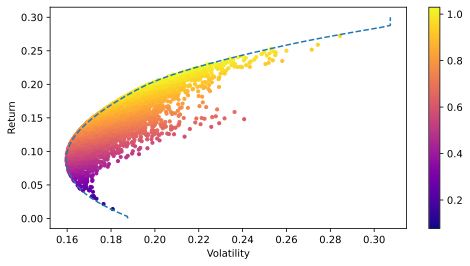

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(vol_arr, ret_arr, s=10, c=sharpe_arr, cmap='plasma')
plt.plot(frontier_volatility, frontier_y, '--')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar()

## 参考

1. https://panel.holoviz.org/gallery/portfolio_optimizer.html